<a href="https://colab.research.google.com/github/amedyukhina/biomassters/blob/main/biomassters_all_times_unet_3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%writefile requirements.txt

pandas==1.3.5
scikit-learn==1.0.2
tqdm==4.64.0
numpy==1.21.6
torch
torchvision
scikit-image
matplotlib
pytorch_lightning
urllib3==1.25.4
monai==0.9.1
wandb
boto3==1.26.16
rasterio==1.2.0

Overwriting requirements.txt


In [2]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
from skimage import io

from cachetools import cached, TTLCache

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision.transforms import Compose, Normalize
import torch.nn.functional as F
from torch import nn
from torchvision.io import read_image
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
import pytorch_lightning as pl
import warnings
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import shutil
from scipy import ndimage
from monai.networks.layers import Norm
from monai.networks.nets import UNet, DynUNet
from monai.inferers import sliding_window_inference
import wandb

In [4]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
with open('gdrive/MyDrive/Personal/wandb_apikey') as f:
    key = f.read()

os.environ['WANDB_API_KEY'] = key.rstrip('\n')

### Prepare list of chip IDs

In [6]:
feature_path = 'gdrive/MyDrive/biomassters/info/features_metadata.csv'
data_path = 'gdrive/MyDrive/biomassters/data/'

# train_img_dir = data_path + 'train_features'
# test_img_dir = data_path + 'test_features'
# label_dir = data_path + 'train_agbm'
train_img_dir = 'train_features'
test_img_dir = 'test_features'
label_dir = 'train_agbm'

model_checkpoint_path = 'gdrive/MyDrive/biomassters/models/'
ntrain = 200
nval = 20
PATCH_SIZE = 32

In [7]:
df = pd.read_csv(feature_path)
df_pred = df[df['split'] == 'test'].reset_index(drop=True)
pred_ids = np.unique(df_pred['chip_id'])
df = df[df['split'] == 'train'].reset_index(drop=True)
all_ids = np.unique(df['chip_id'])

np.random.seed(42)
np.random.shuffle(all_ids)
train_ids = all_ids[:ntrain]
val_ids = all_ids[ntrain:ntrain+nval]

### Set up data loading

In [8]:
cache = TTLCache(maxsize=1000, ttl=86400)

In [9]:

import boto3
from botocore import UNSIGNED
from botocore.config import Config
import rasterio

# Our rasters contain no geolocation info, so silence this warning from rasterio
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

BUCKET_NAME = 'drivendata-competition-biomassters-public-us'
os.environ["AWS_NO_SIGN_REQUEST"] = 'YES'
s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))

@cached(cache)
def get_image(fn, nchannels):
  try:
    obj = s3.get_object(Bucket=BUCKET_NAME, Key=fn)
    with rasterio.open(obj['Body']) as src:
      img = src.read()
  except:
    img = np.zeros((nchannels, 256, 256))
  return img

In [10]:
# @cached(cache)
# def get_image(fn, nchannels):
#     if os.path.exists(fn):
#         img = io.imread(fn)
#         if img.shape[-1] < 20:
#             img = np.moveaxis(img, -1, 0)
#     else:
#         img = np.zeros((nchannels, 256, 256))
#     return img

In [11]:
MEANS_S1, STDS_S1 = np.load(data_path + rf's1_mean_std.npy')
MEANS_S1 = MEANS_S1.reshape(-1,1,1)
STDS_S1 = STDS_S1.reshape(-1,1,1)

MEANS_S2, STDS_S2 = np.load(data_path + rf's2_mean_std.npy')
MEANS_S2 = MEANS_S2.reshape(-1,1,1)
STDS_S2 = STDS_S2.reshape(-1,1,1)

MEANS = np.concatenate([MEANS_S1, MEANS_S2])
STDS = np.concatenate([STDS_S1, STDS_S2])

### Define a dataset

In [12]:
class SentinelDataset(Dataset):
    def __init__(self, chip_ids, img_dir, label_dir=None, 
                 transform=None):
        self.chip_ids = chip_ids
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        image = []
        for month in range(12):
            img1 = get_image(os.path.join(self.img_dir, 
                                          rf"{self.chip_ids[idx]}_S1_{month:02d}.tif"),
                             len(MEANS_S1))
            img1 = torch.tensor(img1.astype(np.float32))
            img2 = get_image(os.path.join(self.img_dir, 
                                          rf"{self.chip_ids[idx]}_S2_{month:02d}.tif"),
                             len(MEANS_S2))
            img2 = torch.tensor(img2.astype(np.float32))
            image.append(torch.concat([img1, img2]))
        image = torch.stack(image)
        t, c, h, w = image.shape
        
        if self.label_dir is not None:
            label = get_image(os.path.join(self.label_dir, 
                                           rf"{self.chip_ids[idx]}_agbm.tif"), 1)
            label_filt = ndimage.median_filter(label[0], 3)
            label_filt = torch.tensor(label_filt.astype(np.float32)).unsqueeze(0)
            label = torch.tensor(label.astype(np.float32))
        else:
            label = label_filt = None

        
        if self.transform:
            image = self.transform(torch.concat([image.reshape(t*c, h, w), 
                                                 label, label_filt]))
            label = image[-2:-1]
            label_filt = image[-1:]
            image = image[:-2].reshape(t, c, h, w)

        image = torch.stack([(img - torch.tensor(MEANS))/torch.tensor(STDS) 
                for img in image])
        image[image < -100] = 0
            
        return image, label, label_filt

In [13]:
train_transforms = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        # transforms.RandomRotation(degrees=180),
    ])

In [14]:
train_ds = SentinelDataset(train_ids, train_img_dir, label_dir, 
                            transform=train_transforms
                            )
val_ds = SentinelDataset(val_ids, train_img_dir, label_dir)
train_dataloader = DataLoader(train_ds, batch_size=4, 
                              shuffle=True, num_workers = 2)
valid_dataloader = DataLoader(val_ds, batch_size=4, 
                              shuffle=False, num_workers = 2)

In [15]:
torch.random.manual_seed(42)

In [16]:
%%time
imgs, labels, labels_filt = next(iter(train_dataloader))

CPU times: user 118 ms, sys: 55.6 ms, total: 173 ms
Wall time: 23.8 s


In [17]:
imgs.shape, labels.shape

(torch.Size([4, 12, 15, 256, 256]), torch.Size([4, 1, 256, 256]))

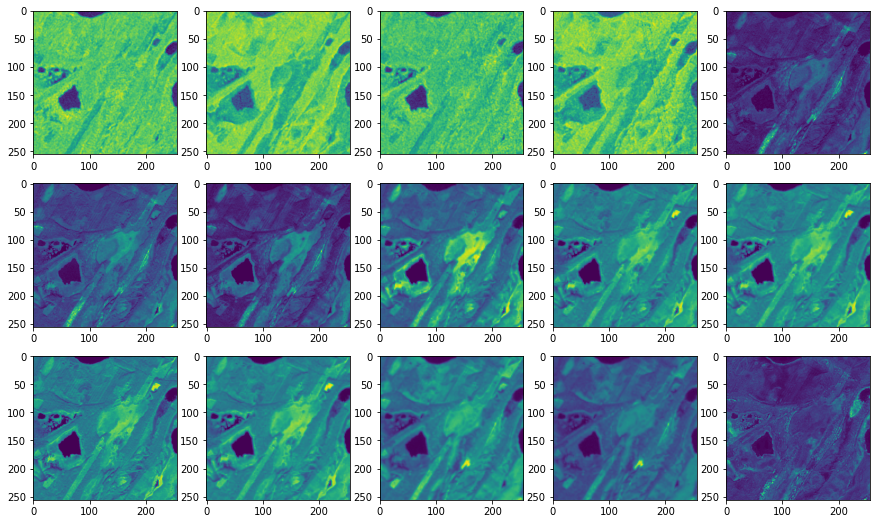

In [18]:
cols = 5
rows = 3
s = 3
fig, axes = plt.subplots(rows, cols, figsize=(s*cols, s*rows))
for img, ax in zip(imgs[0][0], axes.ravel()):
    ax.imshow(img.numpy())

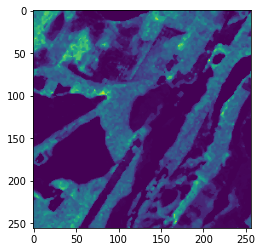

In [19]:
# Show ground truth
plt.imshow(labels_filt[0][0].numpy())

### Define the model and the training pipeline

In [20]:
class SentinelModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def training_step(self, batch, batch_idx):
        # img, _, label = batch
        img, label, _  = batch
        predicted = self.model(img)
        loss = F.mse_loss(predicted, label)
        self.log("train/loss", loss)
        self.log("train/rmse", torch.sqrt(loss))
        return loss
    
    def validation_step(self, batch, batch_idx):
        img, label, label_filt = batch
        predicted = self.model(img)
        loss = F.mse_loss(predicted, label_filt)
        self.log("valid_loss", loss)
        self.log("valid_rmse", torch.sqrt(loss))
        self.log("valid_rmse_nonfilt", torch.sqrt(F.mse_loss(predicted, label)))
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.02)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
        return [optimizer], [scheduler]
    
    def forward(self, x):
        return self.model(x)

In [21]:
kernels = [[1, 5, 5], [3, 3, 3], [1, 3, 3], [3, 3, 3]]
strides = [[1, 1, 1], [2, 2, 2], [1, 2, 2], [2, 2, 2]]

class Unet3D(nn.Module):
    def __init__(self, kernels, strides):
        super(Unet3D, self).__init__()
        self.unet = DynUNet(
            spatial_dims=3,
            in_channels=len(MEANS),
            out_channels=1,
            kernel_size=kernels,
            strides=strides,
            upsample_kernel_size=strides[1:],
            norm_name="batch",
            deep_supervision=False,
            deep_supr_num=3,
        )
        self.conv = nn.Conv3d(12, 1, kernel_size=1, stride=1, padding=0)

    def forward(self, img):
        out = self.unet(img.transpose(1,2))
        return self.conv(out.transpose(1,2)).squeeze(1)
        

base_model = Unet3D(kernels, strides)

In [22]:
s2_model = SentinelModel(base_model)

In [23]:
# from functools import reduce

# features = []

# def get_module_by_name(module, access_string):
#     names = access_string.split(sep='.')
#     return reduce(getattr, names, module)

# def _get_features(module, inp, output):
#     features.append(output)

# modules = ['input_block'] + [rf'downsamples.{i}' for i in range(len(strides)-2)] + ['bottleneck']
# print(modules)

# for module in modules:
#     get_module_by_name(base_model.unet, module).register_forward_hook(_get_features)

# base_model.cuda().eval();
# out = base_model(imgs.cuda())
# for feature in features:
#   print(feature.shape)

In [24]:
wandb_logger = WandbLogger(project='BioMassters_all_timepoints')

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: amedyukh. Use `wandb login --relogin` to force relogin


In [25]:
checkpoint_callback = ModelCheckpoint(
     monitor='valid_rmse',
     dirpath=os.path.join(model_checkpoint_path, wandb.run.name),
     filename='{epoch:02d}-{valid_rmse:.2f}')
lr_monitor = LearningRateMonitor(logging_interval='step')

In [26]:
# Initialize a trainer
trainer = Trainer(
    accelerator="gpu",
    max_epochs=30,
    logger=[wandb_logger],
    callbacks=[checkpoint_callback, lr_monitor],
    log_every_n_steps=5
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Train

In [ ]:
%%time
# Train the model ⚡
torch.random.manual_seed(42)
trainer.fit(s2_model, train_dataloaders=train_dataloader, 
            val_dataloaders=valid_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type   | Params
---------------------------------
0 | model | Unet3D | 4.9 M 
---------------------------------
4.9 M     Trainable params
0         Non-trainable params
4.9 M     Total params
19.655    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

### Show example predictions

In [ ]:
model_name = wandb.run.name
# model_name = 'playful-field-16'
fn = os.listdir(os.path.join(model_checkpoint_path, model_name))[0]
s2_model.load_state_dict(torch.load(os.path.join(model_checkpoint_path, model_name, fn))['state_dict'])
s2_model.eval().cuda();

In [ ]:
imgs, labels, _ = next(iter(valid_dataloader))
pred = s2_model(imgs.cuda())

In [ ]:
s = 7
fig, axes = plt.subplots(1, 3, figsize=(s*3, s))
axes[0].imshow(ndimage.median_filter(labels[0].numpy()[0], 3))
axes[1].imshow(pred[0].cpu().detach().numpy()[0])
axes[2].imshow(ndimage.median_filter(labels[0].numpy()[0], 3) - pred[0].cpu().detach().numpy()[0])

### Prediction

In [ ]:
%%time
output_dir = os.path.join(model_checkpoint_path, model_name, 'predicted')
os.makedirs(output_dir, exist_ok=True)
for chip_id in tqdm(pred_ids):
    image = []
    for month in range(12):
        img1 = get_image(rf"test_features/{chip_id}_S1_{month:02d}.tif", 
                                  len(MEANS_S1))
        img1 = torch.tensor(img1.astype(np.float32))
        img2 = get_image(rf"test_features/{chip_id}_S2_{month:02d}.tif", 
                                  len(MEANS_S2))
        img2 = torch.tensor(img2.astype(np.float32))

        img = torch.concat([img1, img2])
        img = (img - torch.tensor(MEANS))/torch.tensor(STDS)
        image.append(img)
    image = torch.stack(image)

    pred = s2_model(image.unsqueeze(0).cuda())
    img = pred.squeeze().cpu().detach().numpy()
    io.imsave(f"{output_dir}/{chip_id}_agbm.tif", img)

In [ ]:
fn = os.path.join(output_dir, '../submission')
shutil.make_archive(fn, 'zip', output_dir)

In [ ]:
from google.colab import files
files.download(fn + '.zip')